In [1]:
#!pip install geopandas

In [2]:
#!pip install plotnine

In [3]:
#!pip install glpk

In [1]:
# Section 1: setup
import geopandas as gpd 
import numpy as np  
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from PIL import Image, ImageOps 
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

2022 Real Illinois Congressional Districts


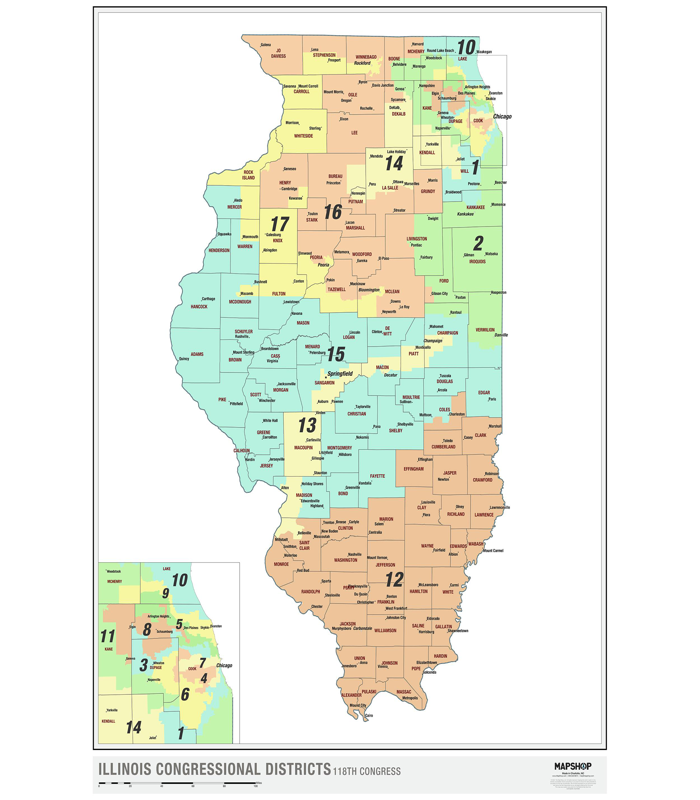

In [2]:
print('2022 Real Illinois Congressional Districts')
Image.open('ILCongress2022.jpg').resize((700,800))

In [3]:
ilcounty_shape_map = (r'C:\Users\tktow\OneDrive\Documents\MSDS460 Decision Analytics\Assignment3_AlgorithmicRedistricting\ilcounty.shp')

In [4]:
county_id = np.arange(0, 102)
county_names = np.array(['Adams County', 'Alexander County', 'Bond County', 'Boone County', 'Brown County', 'Bureau County', 
                         'Calhoun County', 'Carroll County', 'Cass County', 'Champaign County', 'Christian County', 
                         'Clark County', 'Clay County', 'Clinton County', 'Coles County', 'Cook County', 'Crawford County', 
                         'Cumberland County', 'De Witt County', 'DeKalb County', 'Douglas County', 'DuPage County', 
                         'Edgar County', 'Edwards County', 'Effingham County', 'Fayette County', 'Ford County', 
                         'Franklin County', 'Fulton County', 'Gallatin County', 'Greene County', 'Grundy County', 
                         'Hamilton County', 'Hancock County', 'Hardin County', 'Henderson County', 'Henry County', 
                         'Iroquois County', 'Jackson County', 'Jasper County', 'Jefferson County', 'Jersey County', 
                         'Jo Daviess County', 'Johnson County', 'Kane County', 'Kankakee County', 'Kendall County', 
                         'Knox County', 'Lake County', 'LaSalle County', 'Lawrence County', 'Lee County', 'Livingston County', 
                         'Logan County', 'Macon County', 'Macoupin County', 'Madison County', 'Marion County', 
                         'Marshall County', 'Mason County', 'Massac County', 'McDonough County', 'McHenry County', 
                         'McLean County', 'Menard County', 'Mercer County', 'Monroe County', 'Montgomery County', 
                         'Morgan County', 'Moultrie County', 'Ogle County', 'Peoria County', 'Perry County', 'Piatt County', 
                         'Pike County', 'Pope County', 'Pulaski County', 'Putnam County', 'Randolph County', 'Richland County', 
                         'Rock Island County', 'Saline County', 'Sangamon County', 'Schuyler County', 'Scott County', 
                         'Shelby County', 'St. Clair County', 'Stark County', 'Stephenson County', 'Tazewell County', 
                         'Union County', 'Vermilion County', 'Wabash County', 'Warren County', 'Washington County', 
                         'Wayne County', 'White County', 'Whiteside County', 'Will County', 'Williamson County', 
                         'Winnebago County', 'Woodford County']) 
population_by_county = pd.DataFrame({'County_ID': county_id,
                                     'County_Name': county_names,
                                     'Population2020' : [65737, 5240, 16725, 53448, 6244, 33244, 4437, 15702, 13042, 205865, 
                                                         34032, 15455, 13288, 36899, 46863, 5275541, 18679, 10450, 100420, 
                                                         15516, 19740, 932877, 16866, 6245, 34668, 21488, 13534, 37804, 33609, 
                                                         4946, 11985, 52533, 7993, 17620, 3649, 6387, 49284, 27077, 52974, 9287,
                                                         37113, 21512, 22035, 13308, 516522, 107502, 131869, 49967, 714342, 
                                                         109658, 15280, 34145, 35815, 27987, 27238, 310229, 170954, 103998, 
                                                         44967, 265859, 37729, 11742, 13086, 14169, 12297, 15699, 34962, 28288, 
                                                         32915, 14526, 51788, 181830, 20945, 16673, 14739, 3763, 5193, 5637, 
                                                         30163, 15813, 144672, 257400, 23768, 196343, 6902, 4949, 20990, 5400, 
                                                         44630, 131343, 17244, 74188, 11361, 16835, 13761, 16179, 13877, 55691, 
                                                         696355, 67153, 285350, 38467],
                                     'Population2010' : [67103, 8238, 17768, 54165, 6937, 34978, 5089, 15387, 13642, 201081, 
                                                         34800, 16335, 13815, 37762, 53873, 5194675, 19817, 11048, 105160, 
                                                         16561, 19980, 916924, 18576, 6721, 34242, 22140, 14081, 39561, 37069, 
                                                         5589, 13886, 50063, 8457, 19104, 4320, 7331, 50486, 29718, 60218, 9698,
                                                         38827, 22985, 22678, 12582, 515269, 113449, 114736, 52919, 703462, 
                                                         113924, 16833, 36031, 38950, 30305, 32612, 308760, 169572, 110768, 
                                                         47765, 269282, 39437, 12640, 14666, 15429, 12705, 16434, 32957, 30104,
                                                         35547, 14846, 53497, 186494, 22350, 16729, 16430, 4470, 6161, 6006, 
                                                         33476, 16233, 147546, 270056, 24913, 197465, 7544, 5355, 22363, 5994, 
                                                         47711, 135394, 17808, 81625, 11947, 17707, 14716, 16760, 14665, 58498,
                                                         677560, 66357, 295266, 38664],
                                     'Latitude': [39.9879052609, 37.191593361, 38.8868296401, 42.3230756866, 39.9617616288, 
                                                  41.4041459264, 39.1692979289, 42.0687539209, 39.9735467174, 40.1400890018, 
                                                  39.5458317531, 39.3335754723, 38.7541714951, 38.6064621876, 39.5202961461, 
                                                  41.8954290221, 39.0026980674, 39.2733468255, 40.1746293382, 41.8935293191, 
                                                  39.7694547721, 41.8519557671, 39.6785303915, 38.4164943803, 39.0597819407, 
                                                  39.0001785652, 40.597165174, 37.9922926916, 40.4727799619, 37.7627564124, 
                                                  39.3561681629, 41.2851032069, 38.0815539776, 40.4037747348, 37.5181798892, 
                                                  40.8181139287, 41.3531364976, 40.7472371326, 37.7851065199, 39.0100394517, 
                                                  38.3005234344, 39.0855054887, 42.3658182043, 37.4596486226, 41.9388566679, 
                                                  41.1377184724, 41.590577647, 40.9318279821, 42.325322722, 41.3440027805, 
                                                  38.7199480156, 41.7461054437, 40.8915578871, 40.1245363517, 39.8600027881, 
                                                  39.2610229552, 38.8297122608, 38.6495781117, 41.0331711391, 40.2396222297, 
                                                  37.2190501994, 40.4562312432, 42.3243507876, 40.4908916187, 40.0274157084, 
                                                  41.2053450175, 38.2785594463, 39.2310459341, 39.7155561425, 39.6414721595, 
                                                  42.0425663561, 40.7880635936, 38.083736798, 40.0103527451, 39.6224801785, 
                                                  37.4127561973, 37.222980428, 41.2044899818, 38.0520825054, 38.7123597006, 
                                                  41.4673285687, 37.7531363894, 39.7581742368, 40.1580424715, 39.6441138538, 
                                                  39.3911561848, 38.4703210348, 41.0933920308, 42.3518291045, 40.5075329902, 
                                                  37.4712716191, 40.183401621, 38.4461016023, 40.8488341603, 38.3521828118, 
                                                  38.4295611651, 38.0874875679, 41.7562548803, 41.4450504457, 37.7302529228, 
                                                  42.3362603021, 40.7882358798],
                                     'Longitude': [ -91.1884921409,  -89.3376041231,  -89.4355442381,  -88.8233754157,  
                                                   -90.7503556212,  -89.5286557577,  -90.6675721556,  -89.9343041982,  
                                                   -90.247375054,  -88.1991706674,  -89.2772543125,  -87.7877174066,  
                                                   -88.4902374225,  -89.4224823889,  -88.2217534978,  -87.6461407931,  
                                                   -87.7595511478,  -88.2401981662,  -88.9040887049,  -88.7703159232,  
                                                   -88.2173347046,  -88.0855946496,  -87.7455648767,  -88.053300973,  
                                                   -88.5898533622,  -89.0241202321,  -88.2232738465,  -88.9241655023,  
                                                   -90.2074818825,  -88.230465738,  -90.3904985092,  -88.4184956524,  
                                                   -88.5390962907,  -91.1646955496,  -88.2667801291,  -90.925108658,  
                                                   -90.1314083142,  -87.8242979012,  -89.3820759403,  -88.1538411275,  
                                                   -88.9240091565,  -90.3565282985,  -90.2125952059,  -88.8809285275,  
                                                   -88.4286377038,  -87.8618317846,  -88.4287883539,  -90.2132382621,  
                                                   -87.6311845438,  -88.8859379256,  -87.7267298383,  -89.3003092504,  
                                                   -88.5577158078,  -89.3675209057,  -88.9615519316,  -89.924455051,  
                                                   -89.90499843,  -88.9189811153,  -89.3447914374,  -89.9168137955,  
                                                   -88.7077397007,  -90.6778776624,  -88.4524199255,  -88.847324278,  
                                                   -89.8021776433,  -90.7413938887,  -90.1772845526,  -89.4788485523,  
                                                   -90.2015195408,  -88.6192951938,  -89.3207266558,  -89.7599800409,  
                                                   -89.3670210808,  -88.5910866502,  -90.8863042728,  -88.5616201146,  
                                                   -89.1265952453,  -89.2857803179,  -89.825176402,  -88.0851335477,  
                                                   -90.5674126031,  -88.5407417954,  -89.6589101835,  -90.6150952137,  
                                                   -90.474747165,  -88.8055049879,  -89.9283990217,  -89.7974473885,  
                                                   -89.6622542939,  -89.5134035348,  -89.255127403,  -87.732815214,  
                                                   -87.8442748908,  -90.6150375695,  -89.4104744564,  -88.4256137919,  
                                                   -88.1795748823,  -89.9141029918,  -87.9786458597,  -88.9299244512,  
                                                   -89.1608658488,  -89.2111061648]})
population_by_county['Change2010_2020'] = population_by_county['Population2020'] - population_by_county['Population2010']

df_county_names = pd.DataFrame(county_names, columns = ['County'])
df = pd.DataFrame()
df['County']  = county_names
df['CountySort'] = county_id

#shapefile_illinois = gpd.read_file('C:/Users/tktow/OneDrive/Documents/MSDS460 Decision Analytics/Assignment3_AlgorithmicRedistricting/ilcountyshape/ilcounty.shp')
#map_population_by_county_data = shapefile_illinois.merge(population_by_county, left_on='NAME', right_on='County_Name',
                                                         suffixes=('_left', '_right'))
county_populations = np.array(population_by_county['Population2020'])
state_population = sum(county_populations)
print('2020 Illinois Census Population: ', sum(population_by_county['Population2020']))
print('2010 Illinois Census Population: ', sum(population_by_county['Population2010']))
population_by_county.sort_values('Change2010_2020', ascending=False).head(10)

2020 Illinois Census Population:  12812508
2010 Illinois Census Population:  12830632


,County_ID,County_Name,Population2020,Population2010,Latitude,Longitude,Change2010_2020
15,15,Cook County,5275541,5194675,41.895429,-87.646141,80866
98,98,Will County,696355,677560,41.445050,-87.978646,18795
46,46,Kendall County,131869,114736,41.590578,-88.428788,17133
21,21,DuPage County,932877,916924,41.851956,-88.085595,15953
48,48,Lake County,714342,703462,42.325323,-87.631185,10880
9,9,Champaign County,205865,201081,40.140089,-88.199171,4784
31,31,Grundy County,52533,50063,41.285103,-88.418496,2470
66,66,Monroe County,34962,32957,38.278559,-90.177285,2005
55,55,Macoupin County,310229,308760,39.261023,-89.924455,1469
56,56,Madison County,170954,169572,38.829712,-89.904998,1382


In [5]:
pop_per_district = round(state_population/17)

print('The population of Illinois is: ',(state_population))
print(f'Each of the 17 Congressional Districts should have approximately %s people.'%(pop_per_district))

The population of Illinois is:  12812508
Each of the 17 Congressional Districts should have approximately 753677 people.


In [6]:
# Section 2: model variables
n_counties = 102
n_districts = 17

# Create the linear programming model.
model = LpProblem("Supply-Demand-Problem", LpMinimize) 
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) for i in range(1, n_counties+1)]
variable_names.sort() 

# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(102,17)

# The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(102,17)    

In [7]:
# Section 3: the objective function

# This objective minimizes the counties split among multiple districts.
objective_function = lpSum(assignment) 
#model += objective_function

In [8]:
# Section 4: constraints
# Initial Assignment / Allocation Constraints

## Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "" + str(i)
    
# This constraint makes assignment required for allocation.
# At least 20% of population must be allocated for any assignment.
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= sum(county_populations)*assignment[i][j] , "Allocation assignment " + str(i) + str(j)
        if assignment[i][j] == 1:
            model += allocation[i][j] >= assignment[i][j]*0.20*county_populations[i] , "Allocation min " + str(i) + str(j)

# Contiguous districts constraints
# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)
# a 2* in front of the left hand 'assignment' means the county is required to border at least two counties from the same district
for j in range(n_districts):
    model += assignment[0][j] <= assignment[83][j]+assignment[4][j]+assignment[74][j]+assignment[33][j] 
    model += assignment[1][j] <= assignment[90][j]+assignment[76][j] 
    model += assignment[2][j] <= assignment[56][j]+assignment[67][j]+assignment[25][j]+assignment[13][j]
    model += assignment[3][j] <= assignment[100][j]+assignment[19][j]+assignment[62][j]  ## consider Ogle (70)
    model += assignment[4][j] <= assignment[0][j]+assignment[83][j]+assignment[8][j]+assignment[68][j]+assignment[74][j]
    model += assignment[5][j] <= assignment[36][j]+assignment[97][j]+assignment[51][j]+assignment[49][j]+assignment[77][j]+assignment[58][j]+assignment[87][j]
    model += assignment[6][j] <= assignment[74][j]+assignment[30][j]+assignment[41][j]  ## consider for a 2*
    model += assignment[7][j] <= assignment[42][j]+assignment[88][j]+assignment[70][j]+assignment[97][j]
    model += assignment[8][j] <= assignment[83][j]+assignment[59][j]+assignment[64][j]+assignment[68][j]+assignment[4][j]
    model += assignment[9][j] <= assignment[63][j]+assignment[26][j]+assignment[91][j]+assignment[20][j]+assignment[73][j]  ## consider Edgar(22)
    model += assignment[10][j] <= assignment[82][j]+assignment[54][j]+assignment[85][j]+assignment[67][j]
    model += assignment[11][j] <= assignment[16][j]+assignment[39][j]+assignment[17][j]+assignment[14][j]+assignment[22][j]
    model += assignment[12][j] <= assignment[25][j]+assignment[24][j]+assignment[39][j]+assignment[79][j]+assignment[95][j]+assignment[57][j]
    model += assignment[13][j] <= assignment[2][j]+assignment[25][j]+assignment[57][j]+assignment[94][j]+assignment[86][j]+assignment[56][j]
    model += assignment[14][j] <= assignment[69][j]+assignment[20][j]+assignment[22][j]+assignment[11][j]+assignment[17][j]+assignment[85][j]
    model += assignment[15][j] <= assignment[48][j]+assignment[21][j]+assignment[44][j]+assignment[98][j]
    model += assignment[16][j] <= assignment[11][j]+assignment[39][j]+assignment[50][j]
    model += assignment[17][j] <= assignment[85][j]+assignment[14][j]+assignment[11][j]+assignment[39][j]+assignment[24][j]
    model += assignment[18][j] <= assignment[63][j]+assignment[73][j]+assignment[54][j]+assignment[53][j]
    model += assignment[19][j] <= assignment[44][j]+assignment[46][j]+assignment[62][j]+assignment[49][j]+assignment[51][j]+assignment[70][j]
    model += assignment[20][j] <= assignment[9][j]+assignment[22][j]+assignment[14][j]+assignment[69][j]+assignment[73][j]
    model += assignment[21][j] <= assignment[15][j]+assignment[98][j]+assignment[44][j]
    model += assignment[22][j] <= assignment[91][j]+assignment[11][j]+assignment[14][j]+assignment[20][j]
    model += assignment[23][j] <= assignment[79][j]+assignment[92][j]+assignment[96][j]+assignment[95][j]
    model += assignment[24][j] <= assignment[25][j]+assignment[85][j]+assignment[39][j]+assignment[12][j]+assignment[17][j]
    model += assignment[25][j] <= assignment[2][j]+assignment[67][j]+assignment[85][j]+assignment[24][j]+assignment[57][j]+assignment[13][j]+assignment[12][j]  ## relook at 12 after first run
    model += assignment[26][j] <= assignment[45][j]+assignment[37][j]+assignment[91][j]+assignment[9][j]+assignment[63][j]+assignment[52][j]
    model += assignment[27][j] <= assignment[72][j]+assignment[40][j]+assignment[32][j]+assignment[38][j]+assignment[99][j]+assignment[81][j]  ## watch 81 and consider a 2*
    model += assignment[28][j] <= assignment[61][j]+assignment[93][j]+assignment[47][j]+assignment[71][j]+assignment[89][j]+assignment[83][j]+assignment[59][j]
    model += assignment[29][j] <= assignment[34][j]+assignment[81][j]+assignment[96][j]   ## consider Hamilton County (32)
    model += assignment[30][j] <= assignment[74][j]+assignment[84][j]+assignment[68][j]+assignment[55][j]+assignment[41][j]+assignment[6][j]
    model += assignment[31][j] <= assignment[49][j]+assignment[46][j]+assignment[52][j]+assignment[45][j]+assignment[98][j]
    model += assignment[32][j] <= assignment[27][j]+assignment[40][j]+assignment[95][j]+assignment[96][j]+assignment[81][j] ## consider Gallatin County (29)
    model += assignment[33][j] <= assignment[35][j]+assignment[61][j]+assignment[83][j]+assignment[0][j]
    model += assignment[34][j] <= assignment[75][j]+assignment[81][j]+assignment[29][j]  ## consider a 2* assignment
    model += assignment[35][j] <= assignment[65][j]+assignment[33][j]+assignment[61][j]+assignment[93][j]
    model += assignment[36][j] <= assignment[80][j]+assignment[97][j]+assignment[5][j]+assignment[87][j]+assignment[47][j]+assignment[65][j]
    model += assignment[37][j] <= assignment[45][j]+assignment[26][j]+assignment[91][j]
    model += assignment[38][j] <= assignment[78][j]+assignment[72][j]+assignment[27][j]+assignment[99][j]+assignment[90][j]
    model += assignment[39][j] <= assignment[12][j]+assignment[24][j]+assignment[17][j]+assignment[16][j]+assignment[79][j]+assignment[11][j]  ## consider 50
    model += assignment[40][j] <= assignment[94][j]+assignment[57][j]+assignment[95][j]+assignment[32][j]+assignment[27][j]+assignment[72][j]
    model += assignment[41][j] <= assignment[6][j]+assignment[30][j]+assignment[55][j]+assignment[56][j]
    model += assignment[42][j] <= assignment[7][j]+assignment[88][j]
    model += assignment[43][j] <= assignment[76][j]+assignment[60][j]+assignment[75][j]+assignment[99][j]+assignment[90][j]   ## consider Saline County (81)
    model += assignment[44][j] <= assignment[19][j]+assignment[62][j]+assignment[15][j]+assignment[21][j]+assignment[46][j]
    model += assignment[45][j] <= assignment[98][j]+assignment[37][j]+assignment[26][j]+assignment[52][j]+assignment[31][j]
    model += assignment[46][j] <= assignment[19][j]+assignment[44][j]+assignment[98][j]+assignment[31][j]  ## consider DuPage (21)
    model += assignment[47][j] <= assignment[65][j]+assignment[36][j]+assignment[93][j]+assignment[28][j]+assignment[71][j]+assignment[87][j]
    model += assignment[48][j] <= assignment[62][j]+assignment[15][j]
    model += assignment[49][j] <= assignment[51][j]+assignment[19][j]+assignment[46][j]+assignment[31][j]+assignment[52][j]+assignment[58][j]+assignment[101][j]
    model += assignment[50][j] <= assignment[16][j]+assignment[79][j]+assignment[92][j]
    model += assignment[51][j] <= assignment[70][j]+assignment[19][j]+assignment[49][j]+assignment[5][j]+assignment[97][j]
    model += assignment[52][j] <= assignment[45][j]+assignment[26][j]+assignment[63][j]+assignment[101][j]+assignment[49][j]+assignment[31][j]
    model += assignment[53][j] <= assignment[89][j]+assignment[18][j]+assignment[54][j]+assignment[82][j]+assignment[64][j]+assignment[59][j]+assignment[63][j]
    model += assignment[54][j] <= assignment[53][j]+assignment[18][j]+assignment[73][j]+assignment[69][j]+assignment[85][j]+assignment[10][j]+assignment[82][j]
    model += assignment[55][j] <= assignment[41][j]+assignment[30][j]+assignment[68][j]+assignment[82][j]+assignment[67][j]+assignment[56][j]
    model += assignment[56][j] <= assignment[41][j]+assignment[55][j]+assignment[67][j]+assignment[2][j]+assignment[13][j]+assignment[86][j]
    model += assignment[57][j] <= assignment[25][j]+assignment[12][j]+assignment[95][j]+assignment[40][j]+assignment[13][j]  ## consider Washington County (94)
    model += assignment[58][j] <= assignment[87][j]+assignment[5][j]+assignment[77][j]+assignment[49][j]+assignment[101][j]+assignment[71][j]
    model += assignment[59][j] <= assignment[28][j]+assignment[89][j]+assignment[53][j]+assignment[64][j]+assignment[8][j]+assignment[83][j]   ## consider a 2* or removing Schuyler (83)
    model += assignment[60][j] <= assignment[76][j]+assignment[43][j]+assignment[75][j]
    model += assignment[61][j] <= assignment[33][j]+assignment[35][j]+assignment[93][j]+assignment[83][j]+assignment[28][j]
    model += assignment[62][j] <= assignment[3][j]+assignment[19][j]+assignment[44][j]+assignment[48][j] ##consider cook county (15)
    model += assignment[63][j] <= assignment[101][j]+assignment[52][j]+assignment[26][j]+assignment[9][j]+assignment[73][j]+assignment[53][j]+assignment[18][j]
    model += assignment[64][j] <= assignment[59][j]+assignment[53][j]+assignment[82][j]+assignment[8][j]
    model += assignment[65][j] <= assignment[80][j]+assignment[93][j]+assignment[35][j]+assignment[36][j]+assignment[47][j]
    model += assignment[66][j] <= assignment[86][j]+assignment[78][j]
    model += assignment[67][j] <= assignment[55][j]+assignment[82][j]+assignment[10][j]+assignment[85][j]+assignment[25][j]+assignment[2][j]+assignment[56][j]
    model += assignment[68][j] <= assignment[8][j]+assignment[82][j]+assignment[55][j]+assignment[30][j]+assignment[84][j]
    model += assignment[69][j] <= assignment[54][j]+assignment[73][j]+assignment[20][j]+assignment[14][j]+assignment[85][j]
    model += assignment[70][j] <= assignment[19][j]+assignment[100][j]+assignment[51][j]+assignment[88][j]+assignment[7][j]+assignment[97][j]  ## consider a 2* for this one and possibly Boone (3)
    model += assignment[71][j] <= assignment[87][j]+assignment[89][j]+assignment[101][j]+assignment[58][j]+assignment[47][j]+assignment[28][j]
    model += assignment[72][j] <= assignment[78][j]+assignment[94][j]+assignment[40][j]+assignment[27][j]+assignment[38][j]
    model += assignment[73][j] <= assignment[63][j]+assignment[9][j]+assignment[20][j]+assignment[69][j]+assignment[54][j]+assignment[18][j]
    model += assignment[74][j] <= assignment[0][j]+assignment[4][j]+assignment[84][j]+assignment[30][j]+assignment[6][j]
    model += assignment[75][j] <= assignment[43][j]+assignment[81][j]+assignment[34][j]+assignment[60][j]
    model += assignment[76][j] <= assignment[1][j]+assignment[90][j]+assignment[43][j]+assignment[60][j]
    model += assignment[77][j] <= assignment[5][j]+assignment[49][j]+assignment[58][j]
    model += assignment[78][j] <= assignment[66][j]+assignment[86][j]+assignment[94][j]+assignment[72][j]+assignment[38][j]
    model += assignment[79][j] <= assignment[12][j]+assignment[30][j]+assignment[50][j]+assignment[92][j]+assignment[23][j]+assignment[95][j]
    model += assignment[80][j] <= assignment[97][j]+assignment[65][j]+assignment[36][j]
    model += assignment[81][j] <= assignment[99][j]+assignment[27][j]+assignment[32][j]+assignment[29][j]+assignment[34][j]+assignment[75][j]  ## consider Johnson County (43)
    model += assignment[82][j] <= assignment[64][j]+assignment[53][j]+assignment[54][j]+assignment[10][j]+assignment[67][j]+assignment[55][j]+assignment[68][j]
    model += assignment[83][j] <= assignment[33][j]+assignment[61][j]+assignment[28][j]+assignment[59][j]+assignment[8][j]+assignment[4][j]+assignment[0][j]
    model += assignment[84][j] <= assignment[74][j]+assignment[68][j]+assignment[30][j]
    model += assignment[85][j] <= assignment[10][j]+assignment[54][j]+assignment[69][j]+assignment[14][j]+assignment[17][j]+assignment[24][j]+assignment[25][j]+assignment[67][j]
    model += assignment[86][j] <= assignment[56][j]+assignment[13][j]+assignment[94][j]+assignment[78][j]+assignment[66][j]
    model += assignment[87][j] <= assignment[71][j]+assignment[58][j]+assignment[47][j]+assignment[36][j]+assignment[5][j]
    model += assignment[88][j] <= assignment[42][j]+assignment[7][j]+assignment[70][j]+assignment[100][j]
    model += assignment[89][j] <= assignment[71][j]+assignment[101][j]+assignment[63][j]+assignment[53][j]+assignment[59][j]+assignment[28][j]
    model += assignment[90][j] <= assignment[38][j]+assignment[99][j]+assignment[43][j]+assignment[76][j]+assignment[1][j]
    model += assignment[91][j] <= assignment[37][j]+assignment[26][j]+assignment[9][j]+assignment[22][j]  ## consider Douglas (20)
    model += assignment[92][j] <= assignment[50][j]+assignment[23][j]  ## consider Richland Count (79) and/or a 2* assignment
    model += assignment[93][j] <= assignment[65][j]+assignment[35][j]+assignment[61][j]+assignment[28][j]+assignment[47][j]
    model += assignment[94][j] <= assignment[86][j]+assignment[13][j]+assignment[40][j]+assignment[72][j]+assignment[78][j]  ## consider Marion County (57)
    model += assignment[95][j] <= assignment[57][j]+assignment[12][j]+assignment[79][j]+assignment[23][j]+assignment[96][j]+assignment[32][j]+assignment[40][j]
    model += assignment[96][j] <= assignment[32][j]+assignment[95][j]+assignment[23][j]+assignment[29][j]  ## consider Saline County (81)
    model += assignment[97][j] <= assignment[7][j]+assignment[70][j]+assignment[51][j]+assignment[5][j]+assignment[36][j]+assignment[80][j]  ## consider removing Ogle County [70]
    model += assignment[98][j] <= assignment[15][j]+assignment[21][j]+assignment[45][j]+assignment[31][j]+assignment[46][j]
    model += assignment[99][j] <= assignment[90][j]+assignment[38][j]+assignment[27][j]+assignment[81][j]+assignment[43][j]  ## consider Pope County (75)
    model += assignment[100][j] <= assignment[88][j]+assignment[70][j]+assignment[3][j]   ## consider DeKalb (19)
    model += assignment[101][j] <= assignment[89][j]+assignment[71][j]+assignment[58][j]+assignment[49][j]+assignment[52][j]+assignment[63][j]

    
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= 800000 , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= 700000 , "District Size Minimum " + str(j)

# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > 220,000 to be split among up to two districts
for i in range(n_counties): # added
    if county_populations[i] <= 220000: 
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment " + str(i) 
    else:
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments " + str(i)

PulpError: overlapping constraint names: Allocation_assignment_110

In [33]:
# Section 6: solver

# Solve the model.
#!glpsol --help # details on solver parameters
model.solve(GLPK_CMD(options=["--mipgap", "0.05", "--gomory"])) 

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

PulpError: Repeated variable names:
[('X_1011', 2), ('X_1012', 2), ('X_1013', 2), ('X_1014', 2), ('X_1015', 2), ('X_1016', 2), ('X_1017', 2), ('X_111', 2), ('X_112', 2), ('X_113', 2), ('X_114', 2), ('X_115', 2), ('X_116', 2), ('X_117', 2), ('X_211', 2), ('X_212', 2), ('X_213', 2), ('X_214', 2), ('X_215', 2), ('X_216', 2), ('X_217', 2), ('X_311', 2), ('X_312', 2), ('X_313', 2), ('X_314', 2), ('X_315', 2), ('X_316', 2), ('X_317', 2), ('X_411', 2), ('X_412', 2), ('X_413', 2), ('X_414', 2), ('X_415', 2), ('X_416', 2), ('X_417', 2), ('X_511', 2), ('X_512', 2), ('X_513', 2), ('X_514', 2), ('X_515', 2), ('X_516', 2), ('X_517', 2), ('X_611', 2), ('X_612', 2), ('X_613', 2), ('X_614', 2), ('X_615', 2), ('X_616', 2), ('X_617', 2), ('X_711', 2), ('X_712', 2), ('X_713', 2), ('X_714', 2), ('X_715', 2), ('X_716', 2), ('X_717', 2), ('X_811', 2), ('X_812', 2), ('X_813', 2), ('X_814', 2), ('X_815', 2), ('X_816', 2), ('X_817', 2), ('X_911', 2), ('X_912', 2), ('X_913', 2), ('X_914', 2), ('X_915', 2), ('X_916', 2), ('X_917', 2), ('Y_1011', 2), ('Y_1012', 2), ('Y_1013', 2), ('Y_1014', 2), ('Y_1015', 2), ('Y_1016', 2), ('Y_1017', 2), ('Y_111', 2), ('Y_112', 2), ('Y_113', 2), ('Y_114', 2), ('Y_115', 2), ('Y_116', 2), ('Y_117', 2), ('Y_211', 2), ('Y_212', 2), ('Y_213', 2), ('Y_214', 2), ('Y_215', 2), ('Y_216', 2), ('Y_217', 2), ('Y_311', 2), ('Y_312', 2), ('Y_313', 2), ('Y_314', 2), ('Y_315', 2), ('Y_316', 2), ('Y_317', 2), ('Y_411', 2), ('Y_412', 2), ('Y_413', 2), ('Y_414', 2), ('Y_415', 2), ('Y_416', 2), ('Y_417', 2), ('Y_511', 2), ('Y_512', 2), ('Y_513', 2), ('Y_514', 2), ('Y_515', 2), ('Y_516', 2), ('Y_517', 2), ('Y_611', 2), ('Y_612', 2), ('Y_613', 2), ('Y_614', 2), ('Y_615', 2), ('Y_616', 2), ('Y_617', 2), ('Y_711', 2), ('Y_712', 2), ('Y_713', 2), ('Y_714', 2), ('Y_715', 2), ('Y_716', 2), ('Y_717', 2), ('Y_811', 2), ('Y_812', 2), ('Y_813', 2), ('Y_814', 2), ('Y_815', 2), ('Y_816', 2), ('Y_817', 2), ('Y_911', 2), ('Y_912', 2), ('Y_913', 2), ('Y_914', 2), ('Y_915', 2), ('Y_916', 2), ('Y_917', 2)]

In [ ]:
# Section 7: results

result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'County': i,
            'District': j+1,
            'Assignment': int(assignment[i][j].value()*(j+1)),
            'Allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['Assignment'] != 0]
results = results.sort_values(['County', 'District'])
results = results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))
results['Multiple_County_Name'] = results['County_Name'].shift(periods=1)
results['Multiple_District'] = results['District'].shift(periods=1).fillna(99).astype(int)

# Edit the assignment for the case when a county has multiple assignments 
for i in range(0,len(results)):
    if results['County_Name'].loc[i] == results['Multiple_County_Name'].loc[i]:
        results.loc[i, 'Assignment'] =   int(str(results['District'].loc[i]) + \
                                                        str(results['Multiple_District'].loc[i]))
results = results.sort_values(['District','County_Name'])
results.index = results['County_ID']

color_dict = { 1 : 'khaki',
               2 : 'pink',
               3 : 'mediumaquamarine',
               4 : 'plum',
               5 : 'paleturquoise',
               6 : 'lightcoral',
               12: 'grey', 13: 'grey', 14: 'grey', 15: 'grey', 16: 'grey',
               21: 'grey', 23: 'grey', 24: 'grey', 25: 'grey', 26: 'grey',
               31: 'grey', 32: 'grey', 34: 'grey', 35: 'grey', 36: 'grey',
               41: 'grey', 42: 'grey', 43: 'grey', 45: 'grey', 46: 'grey',
               51: 'grey', 52: 'grey', 53: 'grey', 54: 'grey', 56: 'grey',
               61: 'grey', 62: 'grey', 63: 'grey', 64: 'grey', 65: 'grey'}

def illinois_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with population labels
    (2) A map with county labels
    (3) A map with county IDs
    """
    
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='Population2021e', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='County_Name_left', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_ids = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='County_ID', size=5), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels, plot_map_county_ids

map_first_pass = shapefile_illinois.merge(results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
map_first_pass['District'] = map_first_pass['District']+1
map_first_pass_labels = map_first_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
map_first_pass_labels['District'] = map_first_pass_labels['District'].astype('category')
map_first_pass_labels['Assignment'] = map_first_pass_labels['Assignment'].astype("category")

illinois_map(map_first_pass_labels)

In [ ]:
# Section 8: results part 2

# Counties in Multiple Districts
results[['County_Name','District','Allocation']][results.duplicated(subset=['County_Name'],keep=False)].sort_values('County_Name')

# Total Population by District
district_totals = pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
district_totals